In [59]:
"""

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

"""
import os
import h5py
import numpy as np
import random
import json
from PIL import Image

from scipy.misc import imresize
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras import backend as K
from keras import applications

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [47]:
K.image_data_format()

'channels_last'

# Our setup: only 2000 training examples (1000 per class)
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data

# Training a small convnet from scratch: 80% accuracy in 40 lines of code

In [48]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './data/train'
validation_data_dir = './data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [49]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [50]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [51]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [52]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [53]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 48s - loss: 0.7271 - acc: 0.5265 - val_loss: 0.6771 - val_acc: 0.5400
Epoch 2/50
125/125 [==============================] - 46s - loss: 0.6764 - acc: 0.5930 - val_loss: 0.6358 - val_acc: 0.6288
Epoch 3/50
125/125 [==============================] - 46s - loss: 0.6338 - acc: 0.6470 - val_loss: 0.5953 - val_acc: 0.6937
Epoch 4/50
125/125 [==============================] - 46s - loss: 0.5979 - acc: 0.6965 - val_loss: 0.5418 - val_acc: 0.7125
Epoch 5/50
125/125 [==============================] - 45s - loss: 0.5862 - acc: 0.6955 - val_loss: 0.7112 - val_acc: 0.6200
Epoch 6/50
125/125 [==============================] - 47s - loss: 0.5542 - acc: 0.7270 - val_loss: 0.5456 - val_acc: 0.7200
Epoch 7/50
125/125 [==============================] - 47s - loss: 0.5453 - acc: 0.7295 - val_loss: 0.5383 - val_acc: 0.7275
Epoch 8/50
125/125 [==============================] - 45s - loss: 0.5394 - acc: 0.7380 - val_loss: 0.5684 - val_acc: 0.7275
Epoch 9/

In [56]:
model.save_weights('./first_try.h5')

In [57]:
model.load_weights('./first_try.h5')

1/1 [==============================] - 0s
[[  1.07497712e-16]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]
1/1 [==============================] - 0s
[[ 1.]]


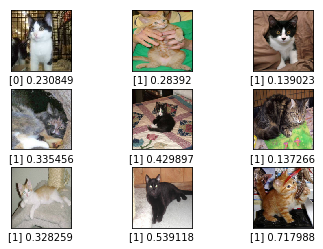

In [58]:
# Create figure with 3x3 sub-plots.
fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axes.flat):
    path = validation_data_dir + '/cats/' + 'cat.' + str(1000 + i) + '.jpg'

    img = load_img(path)
    img = imresize(img, size=(img_height, img_width))

    ax.imshow(img)

    test_x = img_to_array(img).reshape(img_height, img_width, 3)
    test_x = test_x.reshape((1,) + test_x.shape)

    test_generator = test_datagen.flow(test_x,
                                       batch_size=1,
                                       shuffle=False)
    prediction = model.predict_generator(test_generator, 1)[0][0]
    cluster = model.predict_classes(test_x)[0]
    print(model.predict_proba(test_x))

    ax.set_xlabel(str(cluster) + ' ' + str(prediction))

    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()

# Using the bottleneck features of a pre-trained network: 90% accuracy in a minute

In [60]:
# path to the model weights file.
base = './transferLearning/'
# weights_path = base + 'vgg16_weights.h5'

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = base + 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [70]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open(base + 'bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open(base + 'bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

In [75]:
def train_top_model():
    train_data = np.load(open(base + 'bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    validation_data = np.load(open(base + 'bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [71]:
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [76]:
train_top_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 3s - loss: 0.8058 - acc: 0.7520 - val_loss: 0.5141 - val_acc: 0.7963
Epoch 2/50
2000/2000 [==============================] - 2s - loss: 0.3771 - acc: 0.8560 - val_loss: 0.2373 - val_acc: 0.9038
Epoch 3/50
2000/2000 [==============================] - 2s - loss: 0.3322 - acc: 0.8725 - val_loss: 0.2679 - val_acc: 0.8988
Epoch 4/50
2000/2000 [==============================] - 2s - loss: 0.2916 - acc: 0.8850 - val_loss: 0.2783 - val_acc: 0.9025
Epoch 5/50
2000/2000 [==============================] - 3s - loss: 0.2504 - acc: 0.9055 - val_loss: 0.3513 - val_acc: 0.8862
Epoch 6/50
2000/2000 [==============================] - 3s - loss: 0.2411 - acc: 0.9145 - val_loss: 0.3040 - val_acc: 0.9025
Epoch 7/50
2000/2000 [==============================] - 3s - loss: 0.2164 - acc: 0.9135 - val_loss: 0.7029 - val_acc: 0.8037
Epoch 8/50
2000/2000 [==============================] - 3s - loss: 0.1789 - ac

# Visualise with t-SNE

In [77]:
images_path = 'data/train'
num_images = 500

In [88]:
def get_image(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224), Image.ANTIALIAS)  # resize the image to fit into VGG-16
    img = np.array(img.getdata(), np.uint8)
    img = img.reshape(224, 224, 3).astype(np.float32)
    img[:,:,0] -= 123.68 # subtract mean (probably unnecessary for t-SNE but good practice)
    img[:,:,1] -= 116.779
    img[:,:,2] -= 103.939
    img = np.expand_dims(img, axis=0)
    return img

In [79]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [80]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), num_images))]

print("keeping %d images to analyze" % len(images))

keeping 500 images to analyze


In [110]:
activations = []
for idx, image_path in enumerate(images):
    if idx%100==0:
        print("getting activations for %d/%d %s" % (idx+1, len(images), image_path))
    image = get_image(image_path)
#     TODO: trouver la bonne activation
    acts = model.predict(image)[0][0]
    activations.append(acts)

getting activations for 1/500 data/train/cats/cat.137.jpg


ValueError: Error when checking : expected input_6 to have shape (None, None, None, 3) but got array with shape (1, 3, 224, 224)

In [91]:
plt.plot(np.array(activations[0]))
plt.show()

ValueError: x and y can be no greater than 2-D, but have shapes (7,) and (7, 7, 512)

In [95]:
# first run our activations through PCA to get the activations down to 300 dimensions
activations = np.array(activations)
pca = PCA(n_components=300)
pca.fit(activations)
pca_activations = pca.transform(activations)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
# then run the PCA-projected activations through t-SNE to get our final embedding
X = np.array(pca_activations)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.2).fit_transform(X)

In [ ]:
# normalize t-sne points to {0,1}
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 3000
height = 3000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)))

plt.figure(figsize = (12,12))
imshow(full_image)

In [ ]:
full_image.save('tsne_dog_cat.bmp')